Enter image url :https://i.pinimg.com/736x/b5/df/e6/b5dfe680ac754ee3e3ec634e8c3f230a--gorgeous-men-black-men.jpg
[ 0 48 80]
[ 20 255 255]
['dark']


(0.0, 1.0, 0.0, 1.0)

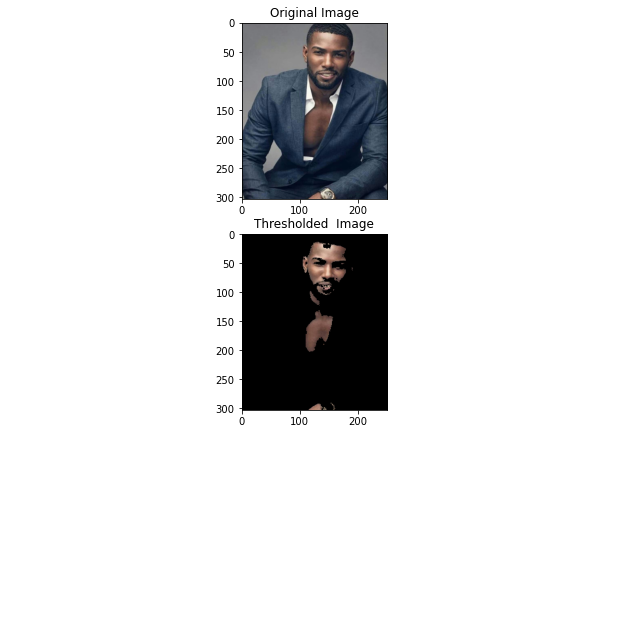

In [20]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[11,11]


rgb_lower = [44,33,29]
rgb_higher = [255,221,171]

skin_shades = {
    'dark' : [rgb_lower,[151,100,79]],
    'mild' : [[151,100,79],[169,131,90]],
    'fair':[[169,131,90],rgb_higher]
}

convert_skintones = {}
for shade in skin_shades:
    convert_skintones.update({
        shade : [
            (skin_shades[shade][0][0] * 255 * 255) + (skin_shades[shade][0][1] * 255) + skin_shades[shade][0][2],
            (skin_shades[shade][1][0] * 255 * 255) + (skin_shades[shade][1][1] * 255) + skin_shades[shade][1][2]
        ]
    })

def extractSkin(image):
    img = image.copy()
    black_img = np.zeros((img.shape[0],img.shape[1],img.shape[2]),dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    print(lower_threshold)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
    print(upper_threshold)

    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)
    skin = cv2.bitwise_and(img, img, mask=skinMask)
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

def removeBlack(estimator_labels, estimator_cluster):
    hasBlack = False
    occurance_counter = Counter(estimator_labels)
    def compare(x, y): return Counter(x) == Counter(y)
    for x in occurance_counter.most_common(len(estimator_cluster)):
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]
        if compare(color, [0, 0, 0]) == True:
            del occurance_counter[x[0]]
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break
    return (occurance_counter, estimator_cluster, hasBlack)


def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):
    occurance_counter = None
    colorInformation = []
    hasBlack = False
    if hasThresholding == True:
        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black
    else:
        occurance_counter = Counter(estimator_labels)
    totalOccurance = sum(occurance_counter.values())
    for x in occurance_counter.most_common(len(estimator_cluster)):
        index = (int(x[0]))
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index
        color = estimator_cluster[index].tolist()
        color_percentage = (x[1]/totalOccurance)
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}
        colorInformation.append(colorInfo)
    return colorInformation

def extractDominantColor(image, number_of_colors=1, hasThresholding=False):
    if hasThresholding == True:
        number_of_colors += 1
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((img.shape[0]*img.shape[1]), 3)
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)
    estimator.fit(img)
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


url = input("Enter image url :")

image = imutils.url_to_image(url)

image = imutils.resize(image, width=250)
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

skin = extractSkin(image)
plt.subplot(3, 1, 2)


plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))


plt.title("Thresholded  Image")

unprocessed_dominant = extractDominantColor(skin, number_of_colors=1, hasThresholding=True)

decimal_lower = (rgb_lower[0] * 256 * 256) + (rgb_lower[1] * 256) + rgb_lower[2]
decimal_higher = (rgb_higher[0] * 256 * 256) + (rgb_higher[1] * 256) + rgb_higher[2]
dominantColors = []
for clr in unprocessed_dominant:
    clr_decimal = int((clr['color'][0] * 256 * 256) + (clr['color'][1] * 256) + clr['color'][2])
    if clr_decimal in range(decimal_lower,decimal_higher+1):
        clr['decimal_color'] = clr_decimal
        dominantColors.append(clr)

skin_tones = []
if len(dominantColors) == 0:
    skin_tones.append('Unrecognized')
else:
    for color in dominantColors:
        for shade in convert_skintones:
            if color['decimal_color'] in range(convert_skintones[shade][0],convert_skintones[shade][1]+1):
                skin_tones.append(shade)

print(skin_tones)



plt.subplot(3, 1, 3)
plt.axis("off")

